#### Kaggle Setup

In [1]:
# the data root for kaggle submission
data_root = '/kaggle/input/rsna-2023-abdominal-trauma-detection'
model_path = '/kaggle/input/epoch-1-batch14-pth/epoch_1_batch14.pth'

#### Local Setup

In [2]:
# data_root = '/mnt/d/kaggle/rsna-2023-abdominal-trauma-detection'
# model_path = './models/classifier-v1.pth'
# %matplotlib notebook

In [3]:
import pandas as pd
from collections import OrderedDict
import pydicom
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image
import matplotlib.animation as animation
from IPython.display import HTML
import dotenv
import torch
import torchvision as tv
from torchvision.transforms import v2
import torchvision.models as models
from torch.nn.functional import silu, sigmoid, softmax
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.model_selection import train_test_split
import copy
import gc

from PIL import Image

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [4]:
class Config:
    BATCH_SIZE = 20
    IMAGE_SIZE = 224
    NUM_LAYERS = 30
    NUM_TRAIN_USE = 100
config = Config()

# Prep a gpu (if possible) otherwise default to cpu
torch.cuda.empty_cache()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
infer_type = 'test' # train or test
tags = pd.read_parquet(f'{data_root}/{infer_type}_dicom_tags.parquet')
image_root = f'{data_root}/{infer_type}_images'

test_meta_raw = pd.read_csv(f'{data_root}/{infer_type}_series_meta.csv')
image_paths = image_root + '/' + test_meta_raw['patient_id'].astype(str) + '/' + test_meta_raw['series_id'].astype(str)
test_meta_raw['imgroot'] = image_paths

# filter out images that don't exist
test_meta = test_meta_raw.loc[test_meta_raw['imgroot'].map(os.path.exists)]

In [6]:
patient_scans = test_meta.groupby(['patient_id'], as_index=False).max()[['patient_id', 'series_id']]

image_paths = image_root + '/' + patient_scans['patient_id'].astype(str) + '/' + patient_scans['series_id'].astype(str)
patient_scans['imgroot'] = image_paths

if infer_type == 'train':
    patient_scans = patient_scans.iloc[:config.NUM_TRAIN_USE]
    
submission = pd.read_csv(f'{data_root}/sample_submission.csv')
submission = submission.drop(index=submission.index, axis=0)
submission['patient_id'] = patient_scans['patient_id'].unique()
submission = submission.apply(lambda x: pd.read_csv(f'{data_root}/sample_submission.csv').loc[0], axis=1)
submission['patient_id'] = patient_scans['patient_id'].unique()

## Input Pipeline
Mostly taken from RSNA Training 2 :thumbsup:

In [7]:
image_augment = v2.Compose([
    v2.Resize(config.IMAGE_SIZE, antialias=True),
    v2.CenterCrop((config.IMAGE_SIZE, config.IMAGE_SIZE))
])

# utility functions
def read_image(path):
    ds = torch.from_numpy(pydicom.dcmread(path).pixel_array.astype('float32'))
    ds -= ds.min()
    ds /= ds.max()
    return image_augment(ds.unsqueeze(0))[0]

class MedicalDatabase(Dataset):
    def __init__(self, source: pd.DataFrame, num_elems: int):
        self.source = source
        self.els = num_elems
    def __len__(self):
        return len(self.source)
    def __getitem__(self, idx):
        # 5-tuple of (is_bowel_injury, is_extravasation_injury, kidney (healthy/low/high), liver (healthy/low/high), spleen (healthy/low/high)
        src = self.source.iloc[idx]

        file_names = np.asarray(os.listdir(src['imgroot']))
        idx = np.round(np.linspace(0, len(file_names) - 1, self.els)).astype(int)
        files = [read_image(src['imgroot'] + '/' + x) for x in file_names[idx]]
        files = torch.stack(files)
        # (self.els, config.IMAGE_SIZE, config.IMAGE_SIZE)
        files = files.unsqueeze(1).expand((-1, 3, -1, -1))
        return src.patient_id, files
        

train_db = MedicalDatabase(patient_scans, config.NUM_LAYERS)
train_dl = DataLoader(train_db, batch_size=1, num_workers=2)

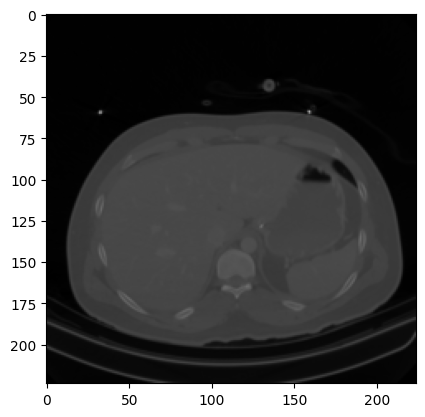

In [8]:
plt.imshow(train_db[2][1][10].moveaxis(0, 2))

## Load Model

In [9]:
network_preparer = v2.Compose([
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        # parameters to fine-tune
        self.tune_params = []
        
        backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT, progress=True)
        for layer in list(backbone.children())[:7]:
            for param in layer.parameters():
                param.requires_grad = False
        for param in backbone.layer4[:2].parameters():
            param.requires_grad = False
        for layer in list(backbone.layer4[2].children())[:4]:
            for param in layer.parameters():
                param.requires_grad = False
        for layer in list(backbone.layer4[2].children())[4:]:
            for param in layer.parameters():
                param.requires_grad = True
                self.tune_params.append(param)

        backbone.fc = nn.Linear(2048, 100)
        self.backbone = backbone
        self.dense1 = nn.Linear(100, 100)
        self.necks = nn.ModuleList([nn.Linear(100, 32) for _ in range(5)])
        self.activate = nn.ModuleList([nn.Linear(32, 1), nn.Linear(32, 1), nn.Linear(32, 3), nn.Linear(32, 3), nn.Linear(32, 3)])
        
        self.init_params = []
        for i in [self.backbone.fc, self.dense1, self.necks, self.activate]:
            self.init_params += list(i.parameters())
        
    def forward(self, x): # batches x images x channels x width x height
        inp_shape = x.shape
        # run network on each image
        x = x.reshape(shape=(-1,*x.shape[2:]))
        x = network_preparer(x) # run some preprocessing
        x = x.clip(0, 1)
        x = self.backbone(x)
        x = silu(x)
        x = silu(self.dense1(x))
        
        # create necks and activate for each image
        x = [silu(i(x)) for i in self.necks]
        x = [silu(i(x[ind])) for ind, i in enumerate(self.activate)]
        
        # split images into batch and image - now it is ([batch x image x answer])
        x = [i.reshape(shape=(*inp_shape[:2], -1)) for ind, i in enumerate(x)]
        
        # calculate means
        x = [i.mean(axis=1) for i in x]
        x = [sigmoid(x[0]).squeeze(dim=1), sigmoid(x[1]).squeeze(dim=1), softmax(x[2], dim=1), softmax(x[3], dim=1), softmax(x[4], dim=1)]
        x = [i.clip(0, 1) for i in x]
        x[0] = x[0].nan_to_num(0.5)
        x[1] = x[1].nan_to_num(0.5)
        x[2] = x[2].nan_to_num(1/3)
        x[3] = x[3].nan_to_num(1/3)
        x[4] = x[4].nan_to_num(1/3)
        return tuple(x)

In [10]:
model = Classifier().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 25.7MB/s]


<All keys matched successfully>

In [11]:
analyze = torch.load(model_path, map_location=device)

In [12]:
analyze['activate.4.bias']

tensor([ 0.2040, -0.0642, -0.1563], device='cuda:0')

## Load Data

In [13]:
for patient_id, data in train_dl:
    idx = patient_id[0].cpu().detach().numpy()
    
    with torch.no_grad():
        images = data.to(device)
        out = model(images)
        out = list(map(lambda i: i.mean(axis=0).detach().cpu().numpy().astype('float64'), out))
    
    print(out)
    out[0] = max(0, min(out[0], 1))
    out[1] = max(0, min(out[1], 1))
    out[2] = np.clip(out[2], 0, 1)
    out[3] = np.clip(out[3], 0, 1)
    out[4] = np.clip(out[4], 0, 1)
    out[2] = out[2] / out[2].sum()
    out[3] = out[3] / out[3].sum()
    out[4] = out[4] / out[4].sum()
    
    to_add = pd.Series({
        'patient_id': idx,
        'bowel_healthy': 1-out[0],
        'bowel_injury': out[0],
        'extravasation_healthy': 1-out[1],
        'extravasation_injury': out[1],
        'kidney_healthy': out[2][0], 
        'kidney_low': out[2][1], 
        'kidney_high': out[2][2],
        'liver_healthy': out[3][0], 
        'liver_low': out[3][1], 
        'liver_high': out[3][2],
        'spleen_healthy': out[4][0], 
        'spleen_low': out[4][1], 
        'spleen_high': out[4][2]
    })
    
    if not to_add.isnull().values.any():
        print(idx)
        submission.loc[submission['patient_id'] == idx] = [to_add]

[array(0.43146339), array(0.4318113), array([0.78205562, 0.10957279, 0.10837153]), array([0.76787448, 0.11334193, 0.11878362]), array([0.73646975, 0.13149178, 0.13203847])]
48843
[array(0.43138671), array(0.43148851), array([0.92122597, 0.03884093, 0.03993316]), array([0.91910732, 0.0414668 , 0.03942587]), array([0.8604328 , 0.07110263, 0.06846457])]
50046
[array(0.43129268), array(0.43150201), array([0.86286813, 0.06833269, 0.06879923]), array([0.85614675, 0.07160106, 0.07225216]), array([0.8040148 , 0.0991402 , 0.09684503])]
63706


In [14]:
submission.astype({'patient_id': 'int32'}).to_csv('submission.csv', index=False, float_format='%.10f')